# Time Series

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Prepare data

- Air Passangers
    - https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download

- ElectricityLoadDiagrams20112014
    - https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

- Metro Interstate Traffic Volume
    - https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [43]:
file_path = "output.xlsx"  # Замените на свой путь
data = pd.read_excel(file_path, index_col=0) 
months = pd.read_excel(file_path)['Month']
print(data)
# data.columns = ["Units"]
# months.columns = ["Month"]
# data["Month"] = pd.to_datetime(data["Month"])
# data.set_index("Month", inplace=True)

               Units
Month               
1956-01-01  7.134094
1956-02-01  7.162397
1956-03-01  7.229114
1956-04-01  7.204893
1956-05-01  7.336286
...              ...
1995-04-01  9.475163
1995-05-01  9.565775
1995-06-01  9.580040
1995-07-01  9.639457
1995-08-01  9.578934

[476 rows x 1 columns]


In [44]:
# df_e = pd.read_table("./data/elec.txt", sep=";", index_col=0)
# df_m = pd.read_csv("./data/metro.csv", sep=",", index_col=0)[['date_time','traffic_volume']].set_index('date_time')
# df_a = pd.read_csv("./data/air.csv", sep=",", index_col=0)

df_a = data

In [45]:
def plot_data(df):
    df.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.show()

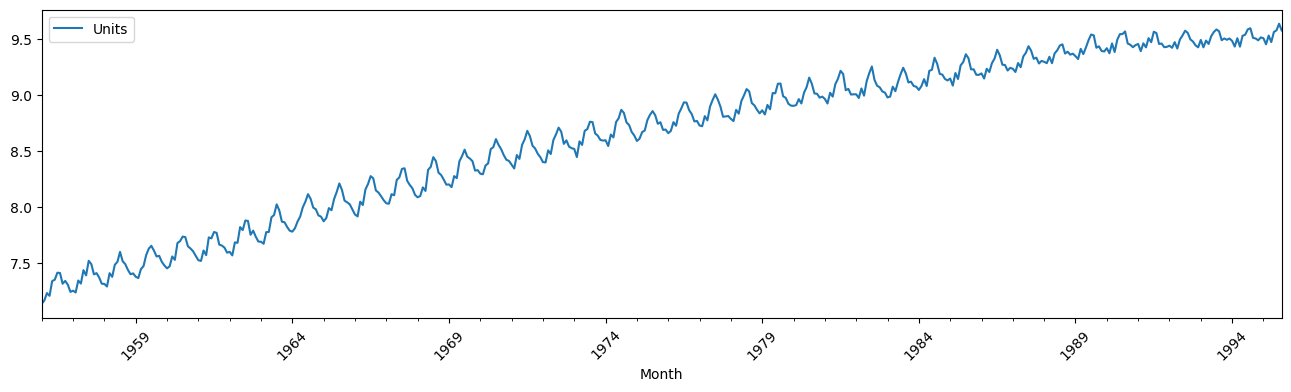

In [46]:
plot_data(df_a)

In [47]:
# df_e['MT_355'] = df_e['MT_355'].replace(',','.', regex=True).astype('float')
# df_e = df_e[['MT_355']][73000:74000]

In [48]:
# plot_data(df_e)

In [49]:
# plot_data(df_m[2500:3000])

In [50]:
df_a = df_a.rename(columns={"Units": "x"})
# df_e = df_e.rename(columns={"MT_355": "x"})


In [51]:
df_a.reset_index(drop=True, inplace=True)
# df_e.reset_index(drop=True, inplace=True)
# df_m.reset_index(drop=True, inplace=True)

## Moving Average

In [52]:
from click import style


def moving_average(series, n):
    return np.average(series[-n:])

def plotMovingAverage(series, window, center=True, plot_intervals=False, scale=1.96, plot_anomalies=False): #2.58 - 99%
    """
    :param series:          dataframe with timeseries
    :param window:          rolling window size
    :param center:          whether to center the window
    :param plot_intervals:  show confidence intervals
    :param plot_anomalies:  show anomalies
    """
    rolling_mean = series.rolling(window=window, center=center).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(series[window:], color="steelblue", linestyle='-', label="Actual values")
    plt.plot(rolling_mean, color="maroon",linestyle='--', label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='maroon', linestyle=":", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, color='maroon', linestyle=":",)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.legend(loc="upper left")
    plt.grid(True)

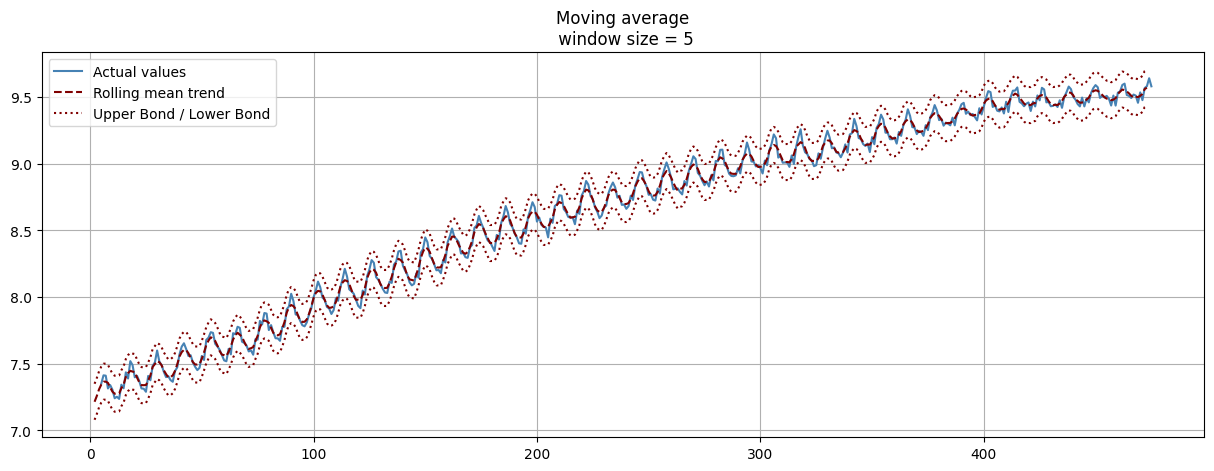

In [53]:
plotMovingAverage(df_a, 5, plot_intervals=True, plot_anomalies=True)

In [54]:
# plotMovingAverage(df_e, 30, plot_intervals=True, plot_anomalies=True)

## Exponential Smooting

In [55]:
def exponential_smoothing(series, alpha):
    """
    :param series: dataset with timestamps
    :param alpha:  float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
    :param series:  dataset with timestamps
    :param alphas:  list of floats, smoothing parameters
    """
    plt.figure(figsize=(15, 7))
    plt.plot(series.values, "c", label = "Actual")
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

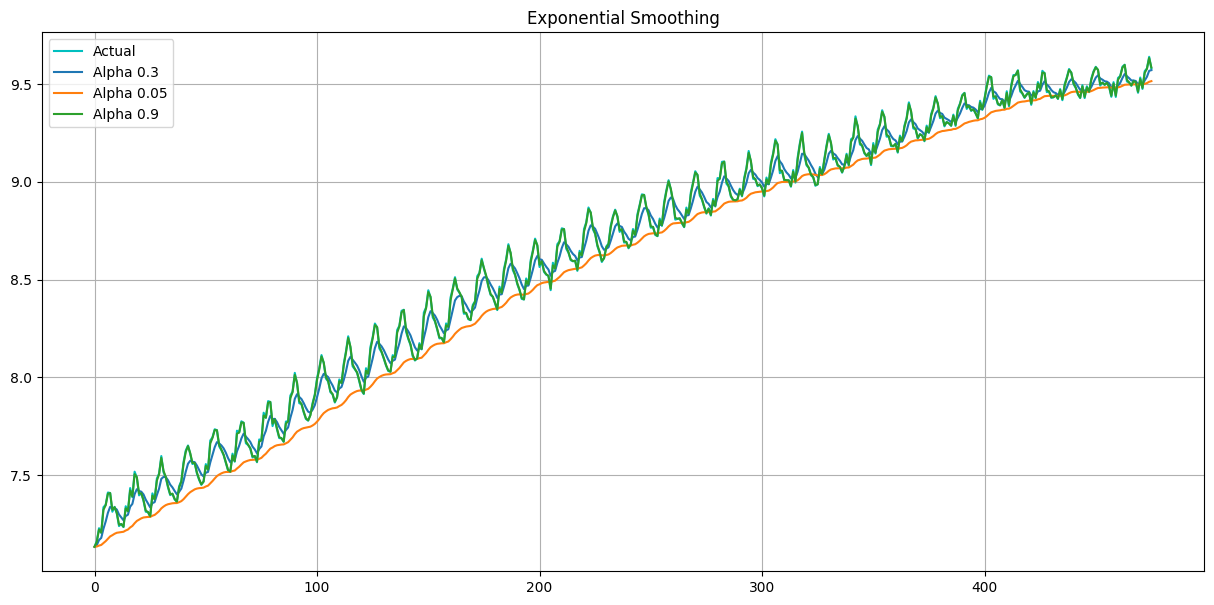

In [56]:
plotExponentialSmoothing(df_a.x, [0.3, 0.05, 0.9])

In [57]:
# plotExponentialSmoothing(df_e.x, [0.3, 0.05])

## Double Exponential Smooting

In [58]:
def double_exponential_smoothing(series, alpha, beta):
    """
    :param series:  dataset with timeseries
    :param alpha:   float [0.0, 1.0], smoothing parameter for level
    :param beta:    float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        # forecasting
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level = level
        level = alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
    :param series:  dataset with timestamps
    :param alphas:  list of floats, smoothing parameters for level
    :param betas:   list of floats, smoothing parameters for trend
    """
    plt.figure(figsize=(20, 8))
    plt.plot(series.values, label = "Actual")
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

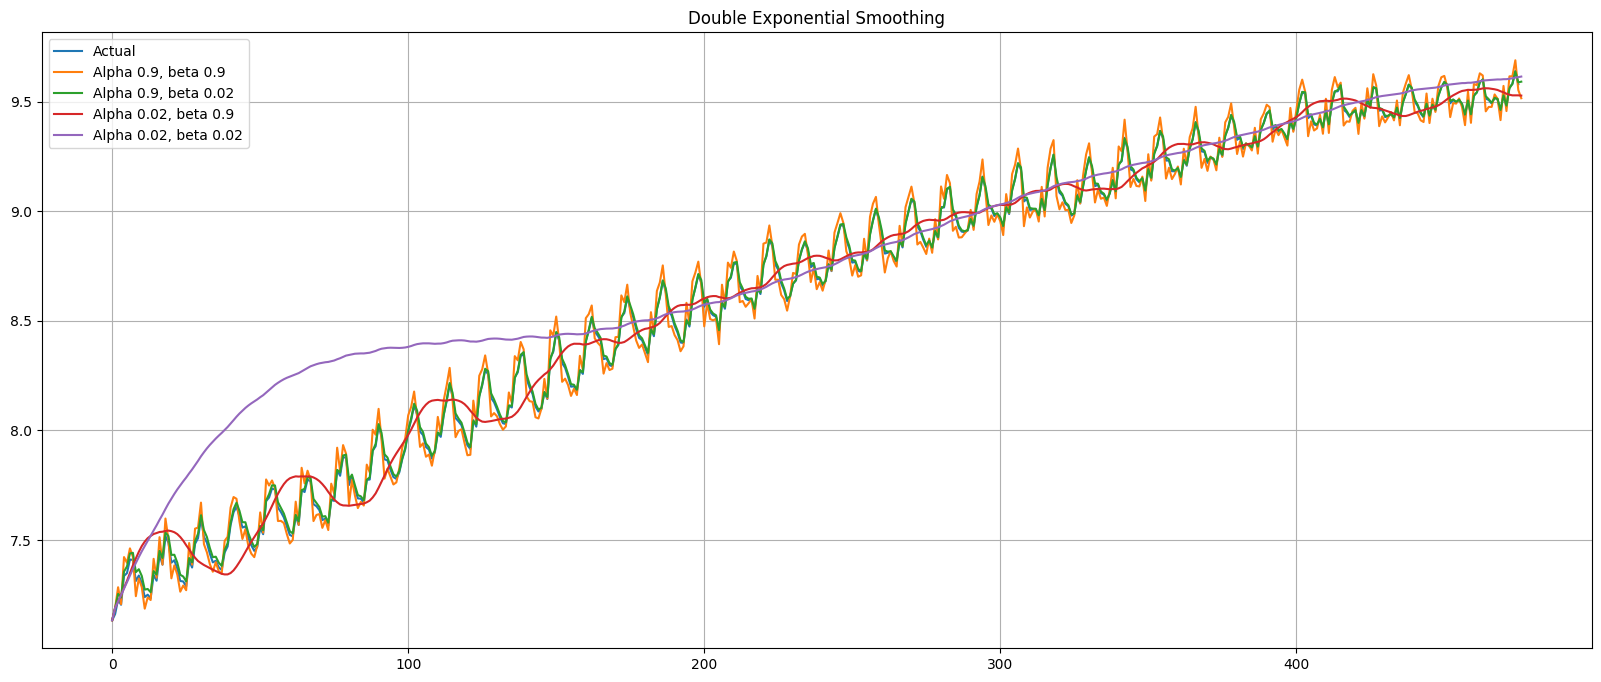

In [59]:
plotDoubleExponentialSmoothing(df_a.x, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [60]:
# plotDoubleExponentialSmoothing(df_e.x, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Triple Exponential Smooting (Holt-Winters)


$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$


Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [61]:
# Длина ряда
n = len(df_a.x)

# Длина тестовой выборки (1/10 от ряда)
test_size = n // 10

# Разделение на обучающую и тестовую выборки
train_data = df_a.x[:-test_size]
test_data = df_a.x[-test_size:]
print(df_a.x)

0      7.134094
1      7.162397
2      7.229114
3      7.204893
4      7.336286
         ...   
471    9.475163
472    9.565775
473    9.580040
474    9.639457
475    9.578934
Name: x, Length: 476, dtype: float64


In [62]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    :param series:          initial time series
    :param slen:            length of a season
    :param alpha:           Holt-Winters model coefficient
    :param beta:            Holt-Winters model coefficient
    :param gamma:           Holt-Winters model coefficient
    :param n_preds:         predictions horizon
    :param scaling_factor:  sets the width of the confidence interval by Brutlag (usually, values from 2 to 3)
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum_ = 0.0
        for i in range(self.slen):
            sum_ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum_ / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

def plotHoltWinters(series, model, n_test_points=0, plot_intervals=False, plot_anomalies=False):
    """
    :param series:          Dataset with timeseries
    :type series:            pd.Series
    :param model:           HoltWinters model
    :type model:             HoltWinters
    :param plot_intervals:  Plot confidence intervals
    :type plot_intervals:    bool
    :param plot_anomalies:  Plot anomalies
    :type plot_anomalies:    bool
    """

    plt.figure(figsize=(20, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    # if plot_anomalies:
    #     anomalies = np.array([np.nan]*len(series))
    #     anomalies[series.values<model.LowerBond[:len(series)]] = \
    #         series.values[series.values<model.LowerBond[:len(series)]]
    #     anomalies[series.values>model.UpperBond[:len(series)]] = \
    #         series.values[series.values>model.UpperBond[:len(series)]]
    #     plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    # if plot_intervals:
    #     plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    #     plt.plot(model.LowerBond, "r--", alpha=0.5)
    #     plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond,
    #                      y2=model.LowerBond, alpha=0.2, color = "grey")

    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-n_test_points, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [63]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=12):
    """
    Returns error on CV
    :param params:         Vector of parameters for optimization
    :type params:           (int, int, int)
    :param series:         Dataset with timeseries
    :type series:           pd.Series
    :param loss_function:  Loss function in the same from as losses from sklearn
    :type loss_function:    function
    :param slen:           Season length for Holt-Winters model
    :type slen:             int
    """
    assert type(series)==pd.Series, "series has to be pd.Series"

    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train],
                            slen=slen,
                            alpha=alpha,
                            beta=beta,
                            gamma=gamma,
                            n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

def find_optimal_HW_parameteres(data, slen):
    # initializing model parameters alpha, beta and gamma
    init_params = [0, 0, 0]
    param_bounds = ((0, 1), (0, 1), (0, 1))

    # Minimizing the loss function
    opt = minimize(timeseriesCVscore,
                   x0=init_params,
                   args=(data, mean_squared_error, slen),
                   method="TNC",
                   bounds=param_bounds)

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x

    print("Alpha =", alpha_final)
    print("Beta  =", beta_final)
    print("Gamma =", gamma_final)

    return alpha_final, beta_final, gamma_final

Alpha = 0.0
Beta  = 0.0
Gamma = 0.0


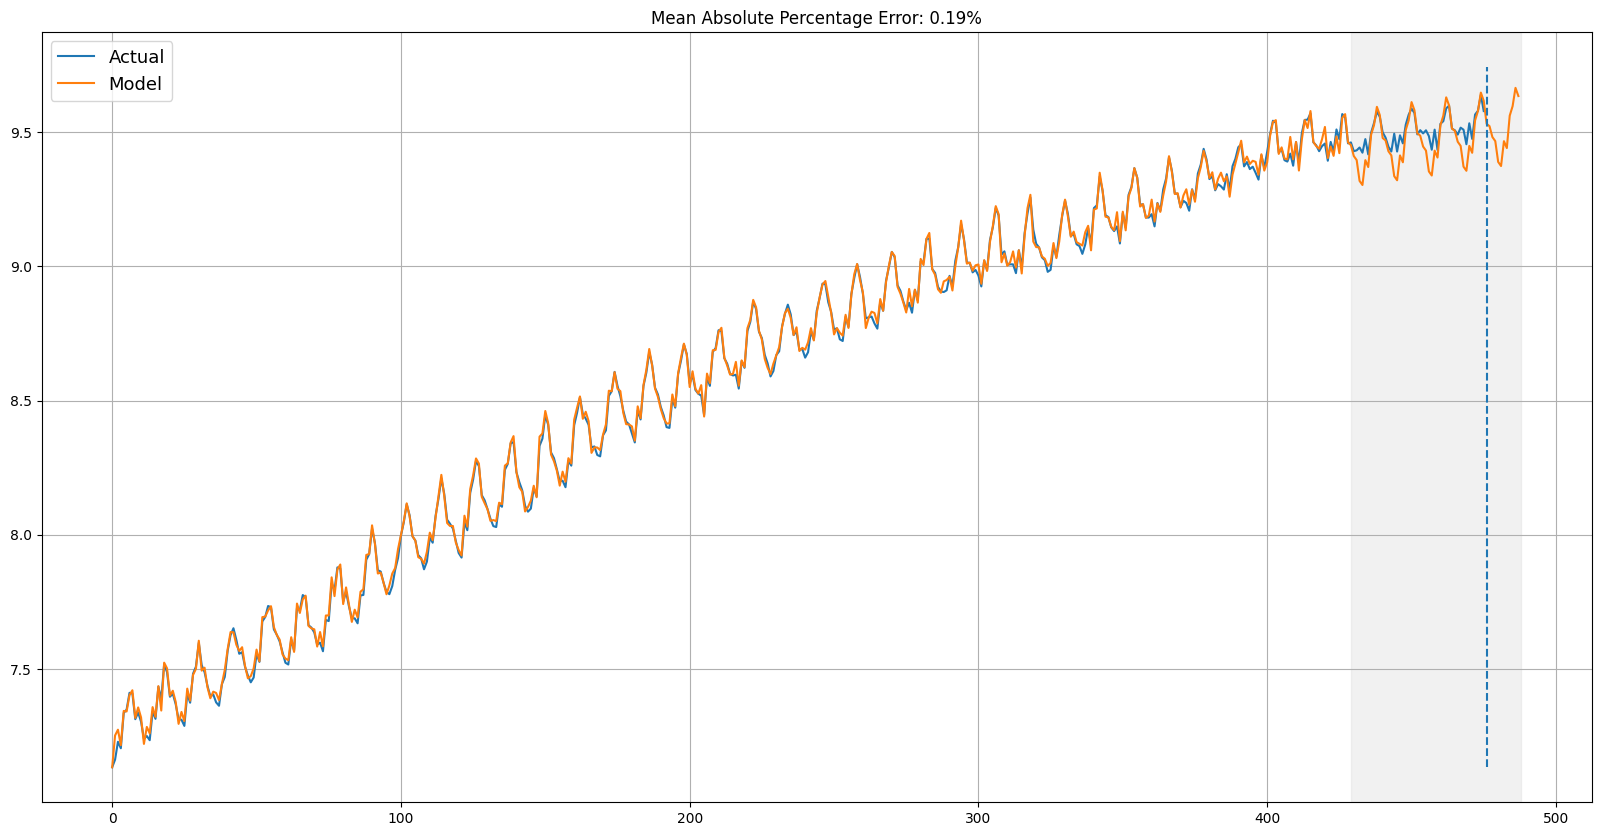

In [96]:
n_test_points = test_size
data = df_a.x[:-n_test_points] # leave some data for testing
SLEN = 12

alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)
alpha_final, beta_final, gamma_final = 0.9, 0.7, 0.01

model = HoltWinters(data,
                    slen=SLEN,
                    alpha=alpha_final,
                    beta=beta_final,
                    gamma=gamma_final,
                    n_preds=n_test_points+SLEN,
                    scaling_factor=3)
model.triple_exponential_smoothing()

plotHoltWinters(df_a.x, model, n_test_points=n_test_points, plot_intervals=True, plot_anomalies=True)

In [65]:
# n_test_points = 200
# data = df_e.x[:-n_test_points] # leave some data for testing
# SLEN = 100

# alpha_final, beta_final, gamma_final = find_optimal_HW_parameteres(data, slen=SLEN)

# model = HoltWinters(data,
#                     slen=SLEN,
#                     alpha=alpha_final,
#                     beta=beta_final,
#                     gamma=gamma_final,
#                     n_preds=n_test_points+SLEN,
#                     scaling_factor=3)
# model.triple_exponential_smoothing()

# plotHoltWinters(df_e.x, model, n_test_points=n_test_points, plot_intervals=False, plot_anomalies=False)

## Time Series Analysis

### Stationarity

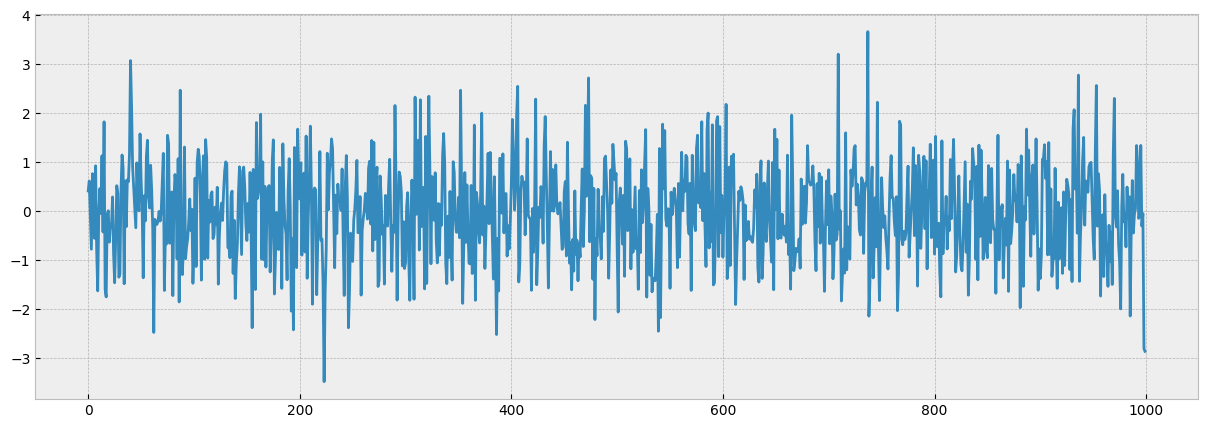

In [66]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Новый процесс: $x_t = \rho x_{t-1} + e_t$

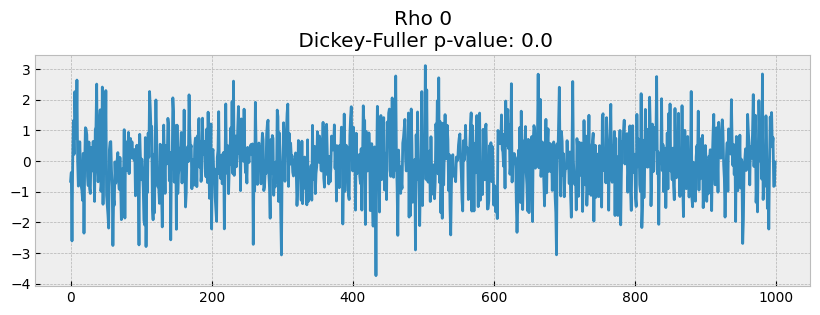

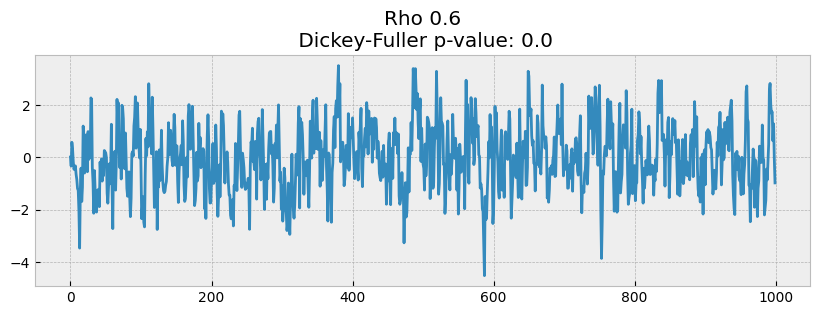

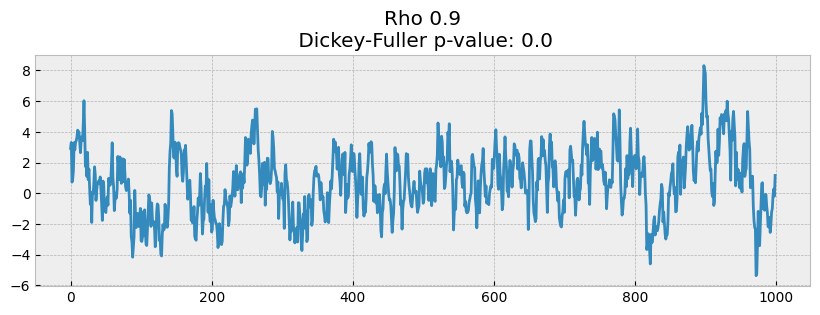

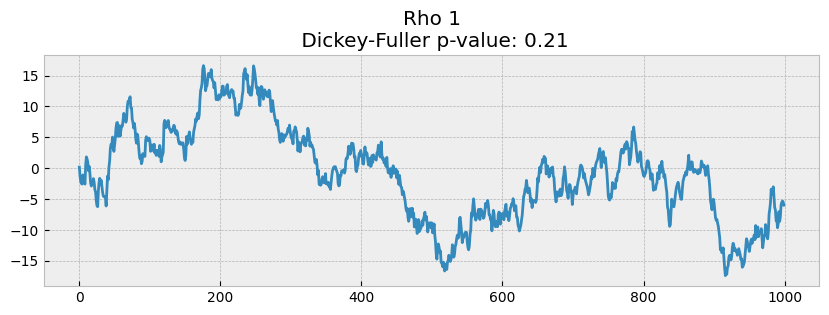

In [67]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

### ARIMA

In [68]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', caption='Time Series Analysis Plots\n'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'{caption} Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

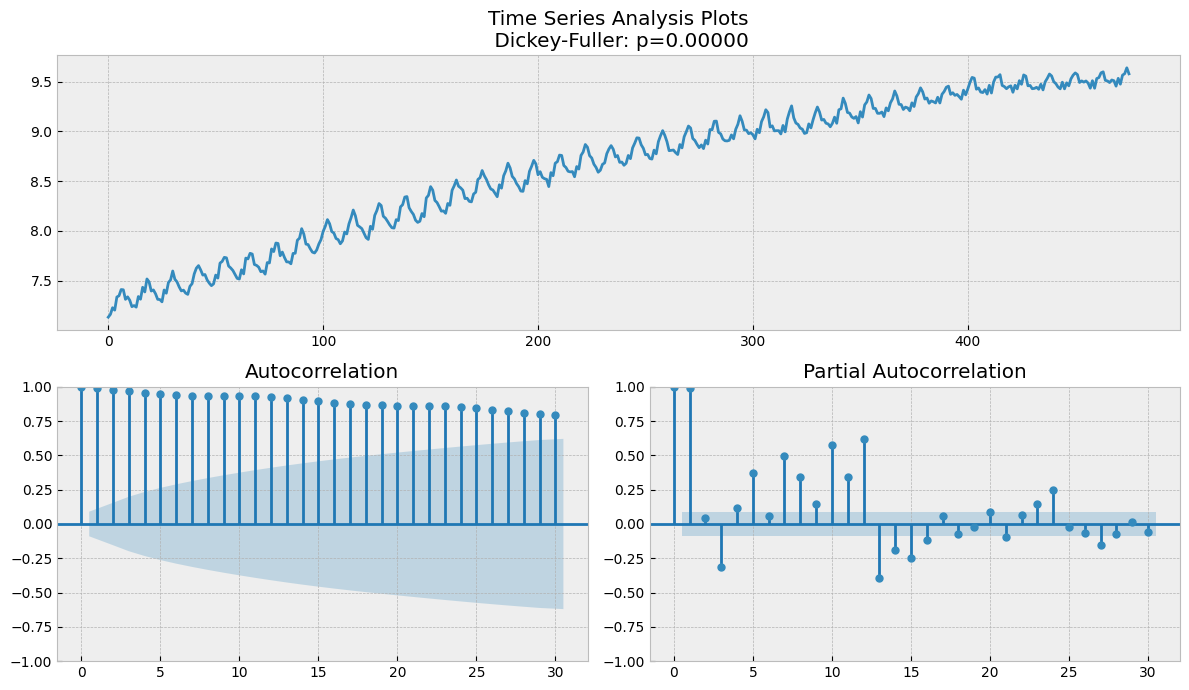

In [69]:
tsplot(df_a.x, lags=30)

In [70]:
# # Конечная разность (первого порядка, численное дифференцирование)
# _diff_1 = df_a.x.values[1:] - df_a.x.values[:-1]
# tsplot(_diff_1, lags=30, caption='Time Series Analysis Plots for 1-st differences\n')

In [71]:
# # Конечная разность (второго порядка)
# # Автокорреляционная функция имеет сильно выраженные сезонные компоненты
# _diff_2 = _diff_1[1:] - _diff_1[:-1]
# tsplot(_diff_2, lags=30, caption='Time Series Analysis Plots for 2-nd differences\n')

In [72]:
# # Преобразование к стационарному виду (преобразование Бокса-Кокса)
# # автокорреляционная функция показывает сезонность
# transfromed_series_a, bc_lamb = boxcox(df_a.x)

# tsplot(transfromed_series_a, lags=30, caption='Time Series Analysis Plots after Box-Cox transformation\n')

<div class="alert alert-info">Преобразование Бокса-Кокса (Box-Cox transformation) - это преобразование, которое преобразует "ненормальные" зависимые переменные в нормальные переменные, так как нормальность является наиболее распространенным предположением при использовании многих статистических методов. Оно было предложено Георгом Боксом и Дэвидом Коксом в 1964 году.

$$x_i(\lambda) =
  \begin{cases}
    \frac{x_i^\lambda - 1}{\lambda}       & \lambda \neq 0 \\
    \ln(x_i)  & \lambda = 0
  \end{cases}
$$

Для того чтобы в результате Бокс-Кокс преобразования закон распределения результирующий последовательности был максимально приближен к нормальному закону, необходимо выбрать оптимальное значение параметра лямбда.

Одним из способов определения оптимальной величины этого параметра является максимизация логарифма функции правдоподобия:

$$
f(x, \lambda) = - \frac{N}{2} \ln\Big[ \displaystyle\sum_{i=1}^{N-1} \frac{\big( x_i(\lambda) - \tilde{x} (\lambda)\big)^2}{N} \Big] + (\lambda + 1) \sum_{i=0}^{N-1} \ln(x_i),
$$

$$
\tilde{x}(\lambda) = \frac{1}{N} \sum_{i=0}^{N-1} x_i (\lambda)
$$

То есть необходимо выбрать такое значение параметра лямбда, при котором данная функция принимает максимальное значение.
</div>


In [73]:
# # Разность первого порядка
# # При этом автокорреляционная функция показывает сезонность
# tsplot(transfromed_series_a[1:] - transfromed_series_a[:-1], lags=30, caption='Time Series Analysis Plots for 1-st differences\n')

In [74]:
# # + Сезонная разность
# diff = transfromed_series_a[1:] - transfromed_series_a[:-1]

# tsplot(diff[12:] - diff[:-12], lags=30, caption='Time Series Analysis Plots for seasonal differences\n')

### Modelling

#### Экспресс-введение в ARIMA-семейство

Cовсем вкратце о самой модели. Начнём по буквам составлять это длинное название $SARIMA(p, d, q)(P, D, Q, s)$, Seasonal Autoregression Moving Average model:

- $AR(p)$ - модель авторегрессии, т.е. регрессии временного ряда на самого себя, в основе лежит предположение о том, что временной ряд зависит от своих предыдущих значений с некоторым лагом (или с несколькими лагами), максимальный лаг, который входит в модель, обозначается буквой $p$. Определить начальное значение $p$ можно при помощи графика PACF по значимому лагу, после которого большинство оставшихся лагов становятся не значимыми.
- $MA(q)$ - модель скользящего среднего, если не вдаваться в детали - моделирует случайные ошибки временного ряда, т.е., как текущая ошибка во временном ряду зависит от предыдущих с некоторым лагом, здесь лаг обозначается буквой $q$. Начальное значение можно определить по графику ACF, логика аналогична.

Немножко остановимся и объединим первые четыре буквы, чтобы посмотреть, что у нас получилось:

$AR(p) + MA(q) = ARMA(p, q)$

А у нас получилась модель авторегрессии - скользящего среднего, если временной ряд стационарен, его можно смело аппроксимировать этими четырьмя буквами. Продолжим-с

- $I(d)$ - порядок интегрированности временного ряда. За этими словами стоит очень простая штука - сколько нам обычных разностей в ряде пришлось взять, чтобы привести его к стационарному, такой порядок интегрированности и будет. В нашем случае это единичка, так как мы взяли от нашего ряда первую разность.

Добавим к нашим четырём буквам и получим модель $ARIMA$, которая умеет работать с нестационарными временными рядами, которые можно привести к стационарным при помощи взятия разностей некоторого порядка. Отлично, осталась последняя буква!

- $S(s)$ - эта буква отвечает за сезонность и равна длине периода сезонности во временном ряде

Прикрепляем последнюю букву и оказывается, что вместо одного дополнительного параметра у нас добавилось сразу три - $(P, D, Q)$

- $P$ - порядок модели авторегрессии для сезонной компоненты, также определяется по PACF, только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 24 и выясняется, что по PACF значим 24-й и 48-й лаг, то для начального приближения можно взять $P = 2$

- $Q$ - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

- $D$ - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет

In [75]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data = data.to_frame()
    print(data.head())
    print(data.columns)
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.nan

    # forecasting on n_steps forward
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = pd.concat([data.arima_model, forecast.predicted_mean])
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    print(len(model_predictions))
    print(len(data.actual))
    plt.plot(months, model_predictions, color='r', label="model")
    plt.plot(months[:-n_steps], data.actual, label="actual")

    # if plot_intervals:
    #     intervals = forecast.conf_int(alpha=alpha)
    #     intervals.columns=['lower', 'upper']
    #     plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
    #     plt.plot(intervals['upper'], "r--", alpha=0.5)
    #     plt.fill_between(x=intervals.index, y1=intervals['upper'],
    #                      y2=intervals['lower'], alpha=0.2, color = "grey")

    plt.legend()
    plt.grid(True)
    return model_predictions

In [76]:
# Длина ряда
n = len(df_a.x)

# Длина тестовой выборки (1/10 от ряда)
test_size = n // 10

# Разделение на обучающую и тестовую выборки
train_data = df_a.x[:-test_size]
test_data = df_a.x[-test_size:]
print(df_a.x)

0      7.134094
1      7.162397
2      7.229114
3      7.204893
4      7.336286
         ...   
471    9.475163
472    9.565775
473    9.580040
474    9.639457
475    9.578934
Name: x, Length: 476, dtype: float64


476
          x
0  7.134094
1  7.162397
2  7.229114
3  7.204893
4  7.336286
Index(['x'], dtype='object')
476
429
Данные успешно сохранены в файл model.xlsx


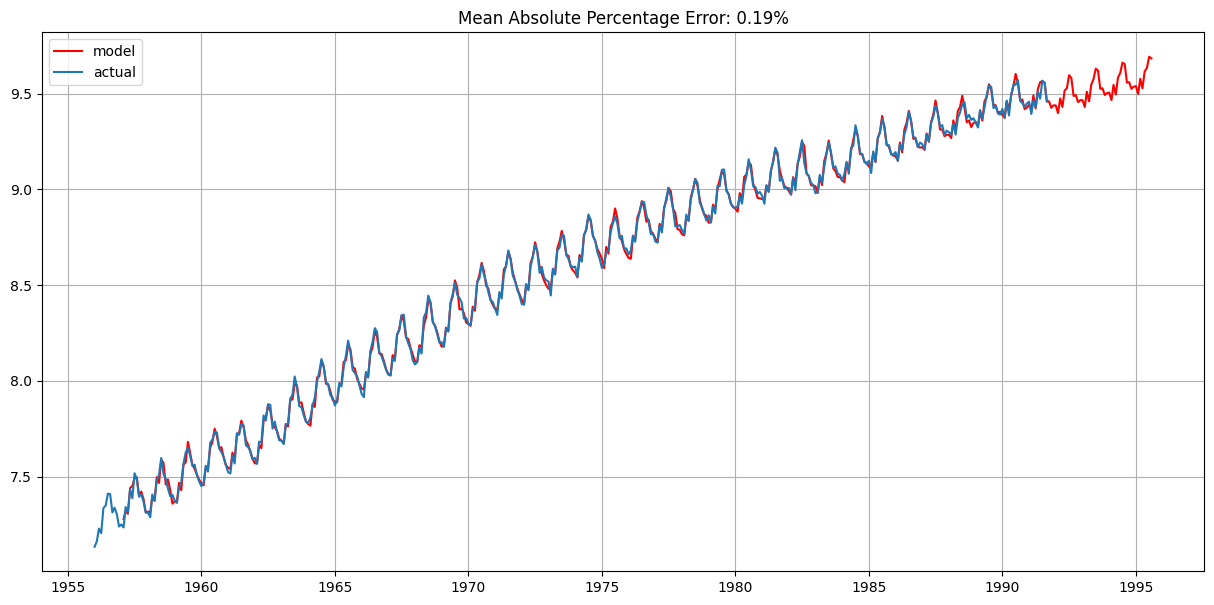

In [77]:
p, d, q = 3, 1, 1
P, D, Q = 3, 1, 1
s = 12

model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)
N = len(df_a.x)
print(N)

model_data = plotSARIMA(train_data, model, n_steps=test_size, s=s, d=d, plot_intervals=True, alpha=0.5)
df = pd.DataFrame(model_data)

# Сохранение в файл Excel
df.to_excel("model.xlsx", index=False)  # index=False, чтобы не сохранять индекс как отдельный столбец

print("Данные успешно сохранены в файл model.xlsx")

## Оптимизируем нашу модель

In [78]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    :param parameters_list:  list with (p, q, P, Q) tuples
    :type parameters_list:    list
    :param d:                integration order in ARIMA model
    :type d:                  int
    :param D:                seasonal integration order
    :type D:                  int
    :param s:                length of season
    :type s:                  int
    """
    results = []
    best_aic = float("inf")

    from tqdm import tqdm

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [79]:
# ps = range(0, 4)
# d = 1
# qs = range(0, 4)
# Ps = range(0, 3)
# # Ps = [0]
# D = 1
# Qs = range(0, 3)
# # Qs = [0]
# s = 12

# # creating list with all the possible combinations of parameters
# parameters_list = list(product(ps, qs, Ps, Qs))
# print(parameters_list)

# result_table = optimizeSARIMA(df_a.x, parameters_list, d, D, s)

In [80]:
result_table.head()

NameError: name 'result_table' is not defined

In [130]:
p, q, P, Q = result_table.parameters[2]
best_model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  x   No. Observations:                  429
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                1014.684
Date:                            Mon, 06 Jan 2025   AIC                          -2017.367
Time:                                    00:16:55   BIC                          -1993.183
Sample:                                         0   HQIC                         -2007.805
                                            - 429                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0016      0.086     -0.018      0.986      -0.171       0.168
ma.L1         -0.6484      0.065   

          x
0  7.134094
1  7.162397
2  7.229114
3  7.204893
4  7.336286
Index(['x'], dtype='object')
476
429


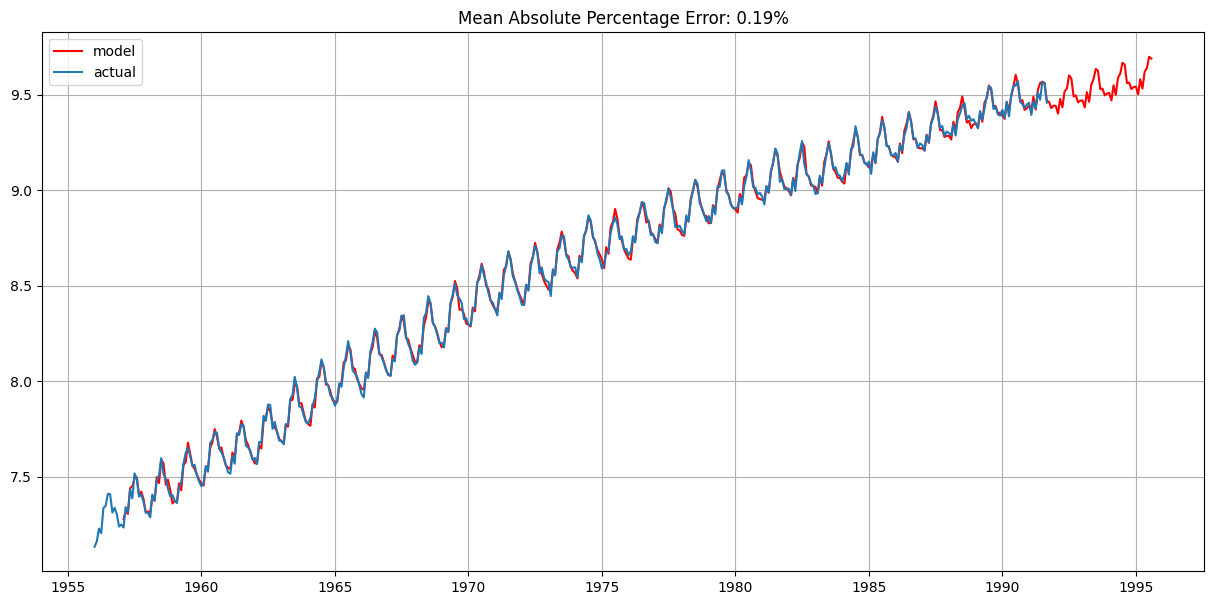

In [ ]:
model2_data=plotSARIMA(train_data, best_model, n_steps=test_size, s=s, d=d, plot_intervals=True, alpha=0.5)

In [132]:
df = pd.DataFrame(model2_data)

# Сохранение в файл Excel
df.to_excel("model2.xlsx", index=False)  # index=False, чтобы не сохранять индекс как отдельный столбец

print("Данные успешно сохранены в файл model.xlsx")

Данные успешно сохранены в файл model.xlsx


# Ссылки

**Блог про сглаживание и Модель Holt-Winters:**

* https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
* https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

**Econometrics:**

* **SARIMAX** from package: https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html


* Лекции и лекционные материалы., Анализ временных рядов. Канторович Г.Г., 2002 г.
* http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
* https://hair-parra.medium.com/a-complete-introduction-to-time-series-analysis-with-r-model-selection-for-arma-p-q-ebc338e6d159
* https://otexts.com/fpp2/arima.html
